In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch import nn

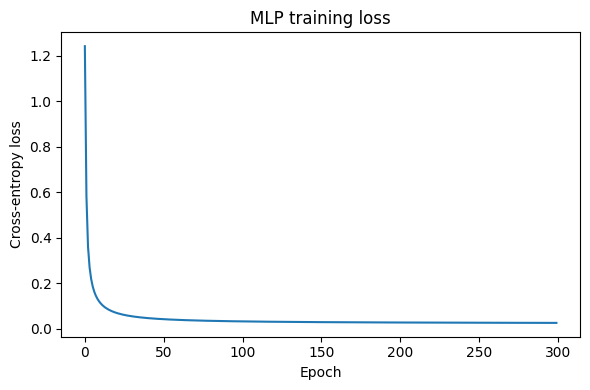

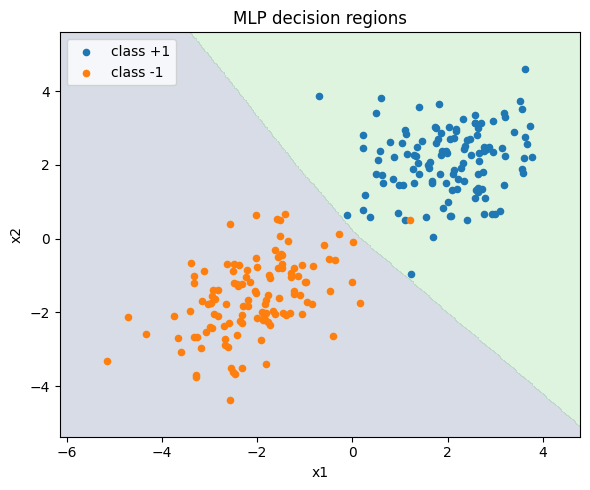

In [16]:
# 資料
np.random.seed(42)
mean_pos = np.array([2.0, 2.0])
mean_neg = np.array([-2.0, -1.5])
cov = np.array([[1.0, 0.3],[0.3, 1.0]])
n_per_class = 120
X_pos = np.random.multivariate_normal(mean_pos, cov, n_per_class)
X_neg = np.random.multivariate_normal(mean_neg, cov, n_per_class)

X = np.vstack([X_pos, X_neg])             # shape: (240, 2)
y = np.hstack([np.ones(n_per_class), -np.ones(n_per_class)])  # labels in {+1, -1}
Xt = torch.from_numpy(X).float()
yt = torch.from_numpy((y>0).astype(int)).long()

# 兩層 MLP
layer1 = nn.Linear(2, 16)
act = nn.ReLU()
layer2 = nn.Linear(16, 2)
loss_fn = nn.CrossEntropyLoss()
lr = 0.1

loss_hist = []
for step in range(300):
    # forward
    h = act(layer1(Xt))
    logits = layer2(h)
    loss = loss_fn(logits, yt)
    loss_hist.append(float(loss.detach()))
    # backward
    for p in list(layer1.parameters()) + list(layer2.parameters()):
        if p.grad is not None:
            p.grad.zero_()
    loss.backward()
    with torch.no_grad():
        for p in list(layer1.parameters()) + list(layer2.parameters()):
            p += -lr * p.grad  # Δw = -lr * grad

# MLP loss 曲線
plt.figure(figsize=(6,4))
plt.plot(loss_hist)
plt.xlabel("Epoch"); plt.ylabel("Cross-entropy loss")
plt.title("MLP training loss")
plt.tight_layout(); plt.show()

# MLP 決策邊界（softmax 最高分類）
xmin, xmax = X[:,0].min()-1.0, X[:,0].max()+1.0
ymin, ymax = X[:,1].min()-1.0, X[:,1].max()+1.0
xx, yy = np.meshgrid(np.linspace(xmin, xmax, 300), np.linspace(ymin, ymax, 300))
with torch.no_grad():
    grid = np.c_[xx.ravel(), yy.ravel()].astype(np.float32)
    grid_t = torch.from_numpy(grid)
    pred_grid = layer2(act(layer1(grid_t))).softmax(dim=1).argmax(dim=1).numpy()
    pred_grid = pred_grid.reshape(xx.shape)

plt.figure(figsize=(6,5))
plt.contourf(xx, yy, pred_grid, levels=[-0.5,0.5,1.5], alpha=0.2)
plt.scatter(X_pos[:,0], X_pos[:,1], s=20, label="class +1")
plt.scatter(X_neg[:,0], X_neg[:,1], s=20, label="class -1")
plt.title("MLP decision regions")
plt.xlabel("x1"); plt.ylabel("x2"); plt.legend(); plt.tight_layout()
plt.show()
